In [ ]:
import cv2
import numpy as np
import torchvision.transforms as transforms
from pathlib import Path
import os



In [ ]:
!yt-dlp https://www.youtube.com/watch?v=5_p5Pztvxiw -o f1_video.mp4 --no-part


[youtube] Extracting URL: https://www.youtube.com/watch?v=5_p5Pztvxiw
[youtube] 5_p5Pztvxiw: Downloading webpage
[youtube] 5_p5Pztvxiw: Downloading tv client config
[youtube] 5_p5Pztvxiw: Downloading player 179bab65-main
[youtube] 5_p5Pztvxiw: Downloading tv player API JSON
[youtube] 5_p5Pztvxiw: Downloading ios player API JSON
[youtube] 5_p5Pztvxiw: Downloading m3u8 information
[info] 5_p5Pztvxiw: Downloading 1 format(s): 136+251
[download] f1_video.mp4.mkv has already been downloaded


In [ ]:
# Set paths
video_path = "input_video.mp4"
output_frames_dir = "processed_frames"
Path(output_frames_dir).mkdir(exist_ok=True)

#  Video to Frame Extraction
def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames


In [ ]:
# 2. Frame Resizing
def resize_frames(frames, size=(224, 224)):
    return [cv2.resize(frame, size) for frame in frames]

# 3. Normalization & Pixel Scaling
def normalize_frames(frames):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return [transform(frame).numpy() for frame in frames]

# 4. Noise Reduction & Smoothing
def smooth_frames(frames, kernel_size=(5, 5)):
    return [cv2.GaussianBlur(frame, kernel_size, 0) for frame in frames]

# 5. Data Augmentation
def augment_frames(frames):
    augmented = []
    for frame in frames:
        flipped = cv2.flip(frame, 1)
        rotated = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        augmented.extend([frame, flipped, rotated])
    return augmented

# 6. Background Subtraction
def subtract_background(frames):
    fgbg = cv2.createBackgroundSubtractorMOG2()
    return [fgbg.apply(frame) for frame in frames]

# 7. Optical Flow
def calc_optical_flow(prev_frame, next_frame):
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray,
                                        None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

# 8. Hue Transformation / Color Analysis
def hue_analysis(frames):
    hue_frames = []
    for frame in frames:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        hue = hsv[:, :, 0]
        hue_frames.append(hue)
    return hue_frames

# 9. Frame Stacking
def stack_frames(frames, stack_size=3):
    stacked = []
    for i in range(len(frames) - stack_size + 1):
        stack = np.stack(frames[i:i+stack_size], axis=0)
        stacked.append(stack)
    return stacked

# 10. Bounding Box Adjustment
def adjust_bounding_boxes(frames):
    return frames




final_frames, normed_frames, stacked, hue_frames, fg_masks = run_preprocessing(video_path)


In [ ]:
import cv2
import json
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
import zipfile
import os


uploaded = files.upload()

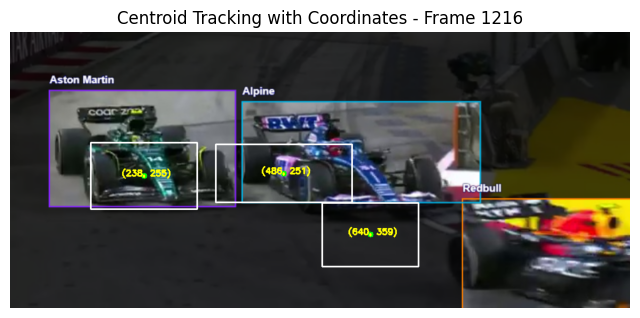

In [ ]:
import cv2
import matplotlib.pyplot as plt

# JSON input data (as a dictionary)
data = {
    "boxes": [
        {
            "id": "1",
            "label": "Redbull",
            "x": "554.29",
            "y": "303.64",
            "width": "171.43",
            "height": "112.71",
            "confidence": None
        },
        {
            "id": "2",
            "label": "Aston Martin",
            "x": "143.71",
            "y": "196.19",
            "width": "188.86",
            "height": "117.81",
            "confidence": None
        },
        {
            "id": "3",
            "label": "Alpine",
            "x": "365.86",
            "y": "199.91",
            "width": "241.71",
            "height": "102.38",
            "confidence": None
        }
    ],
    "height": 360,
    "key": "frame_1216.jpg",
    "width": 640
}

# Load the image
image_path = "/content/ 2025-04-13 154345.png"
image = cv2.imread(image_path)

# Loop over each bounding box, calculate centroid, and draw them
for box in data["boxes"]:
    # Convert string values to float
    x = float(box["x"])
    y = float(box["y"])
    w = float(box["width"])
    h = float(box["height"])

    # Calculate centroid (pixel coordinates)
    cx = int(x + w / 2)
    cy = int(y + h / 2)

    # Draw bounding box (white)
    cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (255, 255, 255), 2)

    # Draw centroid (green dot)
    cv2.circle(image, (cx, cy), 5, (0, 255, 0), -1)

    # Place centroid coordinate text inside the bounding box

    text = f"({cx}, {cy})"
    cv2.putText(image, text, (cx - 40, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

# Convert image to RGB for proper display in matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Centroid Tracking with Coordinates - Frame 1216")
plt.show()


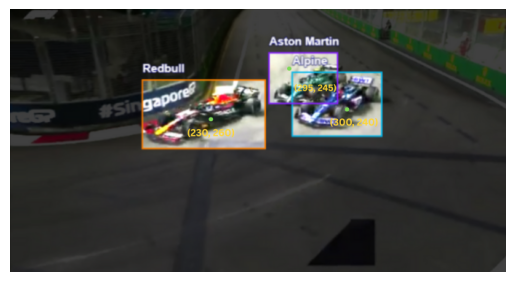

In [ ]:
from scipy.spatial import distance as dist
from collections import OrderedDict

class CentroidTracker:
    def __init__(self, maxDisappeared=40):
        self.nextObjectID = 0
        self.objects = OrderedDict()
        self.disappeared = OrderedDict()
        self.maxDisappeared = maxDisappeared

    def register(self, centroid):
        self.objects[self.nextObjectID] = centroid
        self.disappeared[self.nextObjectID] = 0
        self.nextObjectID += 1



    def update(self, rects):  # rects = [(startX, startY, endX, endY), ...]
        if len(rects) == 0:
            for objectID in list(self.disappeared.keys()):
                self.disappeared[objectID] += 1
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)
            return self.objects

        inputCentroids = np.zeros((len(rects), 2), dtype="int")

        for (i, (startX, startY, endX, endY)) in enumerate(rects):
            cX = int((startX + endX) / 2.0)
            cY = int((startY + endY) / 2.0)
            inputCentroids[i] = (cX, cY)

        if len(self.objects) == 0:
            for i in range(0, len(inputCentroids)):
                self.register(inputCentroids[i])
        else:
            objectIDs = list(self.objects.keys())
            objectCentroids = list(self.objects.values())
            D = dist.cdist(np.array(objectCentroids), inputCentroids)
            rows = D.min(axis=1).argsort()
            cols = D.argmin(axis=1)[rows]

            usedRows = set()
            usedCols = set()

            for (row, col) in zip(rows, cols):
                if row in usedRows or col in usedCols:
                    continue
                objectID = objectIDs[row]
                self.objects[objectID] = inputCentroids[col]
                self.disappeared[objectID] = 0
                usedRows.add(row)
                usedCols.add(col)

            unusedRows = set(range(0, D.shape[0])).difference(usedRows)
            unusedCols = set(range(0, D.shape[1])).difference(usedCols)

            for row in unusedRows:
                objectID = objectIDs[row]
                self.disappeared[objectID] += 1
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)

            for col in unusedCols:
                self.register(inputCentroids[col])

        return self.objects


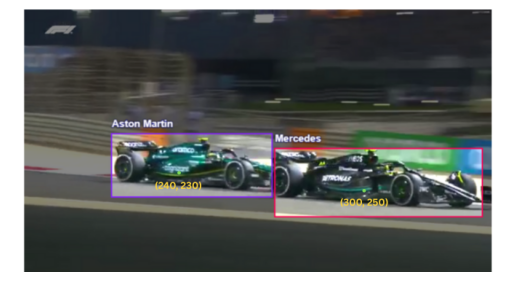

In [ ]:
from scipy.spatial import distance as dist
from collections import OrderedDict

class CentroidTracker:
    def __init__(self, maxDisappeared=40):
        self.nextObjectID = 0
        self.objects = OrderedDict()
        self.disappeared = OrderedDict()
        self.maxDisappeared = maxDisappeared

    def register(self, centroid):
        self.objects[self.nextObjectID] = centroid
        self.disappeared[self.nextObjectID] = 0
        self.nextObjectID += 1



    def update(self, rects):  # rects = [(startX, startY, endX, endY), ...]
        if len(rects) == 0:
            for objectID in list(self.disappeared.keys()):
                self.disappeared[objectID] += 1
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)
            return self.objects

        inputCentroids = np.zeros((len(rects), 2), dtype="int")

        for (i, (startX, startY, endX, endY)) in enumerate(rects):
            cX = int((startX + endX) / 2.0)
            cY = int((startY + endY) / 2.0)
            inputCentroids[i] = (cX, cY)

        if len(self.objects) == 0:
            for i in range(0, len(inputCentroids)):
                self.register(inputCentroids[i])
        else:
            objectIDs = list(self.objects.keys())
            objectCentroids = list(self.objects.values())
            D = dist.cdist(np.array(objectCentroids), inputCentroids)
            rows = D.min(axis=1).argsort()
            cols = D.argmin(axis=1)[rows]

            usedRows = set()
            usedCols = set()

            for (row, col) in zip(rows, cols):
                if row in usedRows or col in usedCols:
                    continue
                objectID = objectIDs[row]
                self.objects[objectID] = inputCentroids[col]
                self.disappeared[objectID] = 0
                usedRows.add(row)
                usedCols.add(col)

            unusedRows = set(range(0, D.shape[0])).difference(usedRows)
            unusedCols = set(range(0, D.shape[1])).difference(usedCols)

            for row in unusedRows:
                objectID = objectIDs[row]
                self.disappeared[objectID] += 1
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)

            for col in unusedCols:
                self.register(inputCentroids[col])

        return self.objects


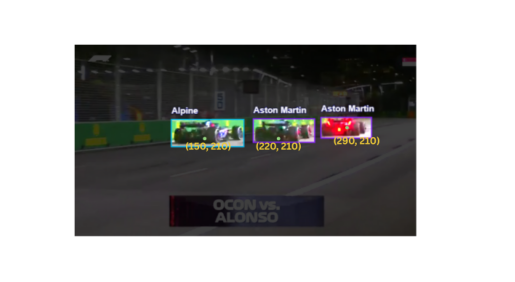

In [ ]:
class OvertakeDetector:
    def __init__(self):
        self.tracks = {}  # objectID -> list of (x, y)

    def update_tracks(self, objects):
        for objectID, centroid in objects.items():
            if objectID not in self.tracks:
                self.tracks[objectID] = []
            self.tracks[objectID].append(centroid)

    def detect_drs_overtake(self):
        overtakes = []
        for id1 in self.tracks:
            for id2 in self.tracks:
                if id1 >= id2:
                    continue
                track1 = np.array(self.tracks[id1])
                track2 = np.array(self.tracks[id2])
                if len(track1) >= 5 and len(track2) >= 5:
                    # Check Y-position switch (e.g., back car becomes front car)
                    if track1[-5][1] > track2[-5][1] and track1[-1][1] < track2[-1][1]:
                        overtakes.append((id1, id2, 'DRS'))
        return overtakes

    def detect_outside_line(self):
        overtakes = []
        for id1 in self.tracks:
            for id2 in self.tracks:
                if id1 >= id2:
                    continue
                track1 = np.array(self.tracks[id1])
                track2 = np.array(self.tracks[id2])
                if len(track1) >= 5 and len(track2) >= 5:
                    # Lateral (X) movement difference with overlap in Y
                    lateral_diff = abs(track1[-1][0] - track2[-1][0])
                    vertical_overlap = abs(track1[-1][1] - track2[-1][1]) < 30
                    if lateral_diff > 40 and vertical_overlap:
                        overtakes.append((id1, id2, 'Outside'))
        return overtakes


In [ ]:
ct = CentroidTracker()
detector = OvertakeDetector()


for frame in video_frames:
    bboxes = detect_cars(frame)
    objects = ct.update(bboxes)
    detector.update_tracks(objects)

drs_overtakes = detector.detect_drs_overtake()
outside_overtakes = detector.detect_outside_line()

print("Detected DRS Overtakes:", drs_overtakes)
print("Detected Outside Line Overtakes:", outside_overtakes)


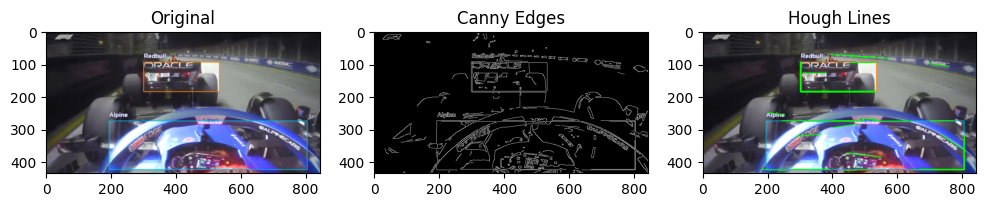

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image_path = '/content/2025-04-13 202036.png'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Canny edge detection
edges = cv2.Canny(gray, 100, 200)

# Hough Line Transform
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)
line_image = np.copy(image)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Plot everything
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title("Canny Edges")
plt.imshow(edges, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Hough Lines")
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.show()


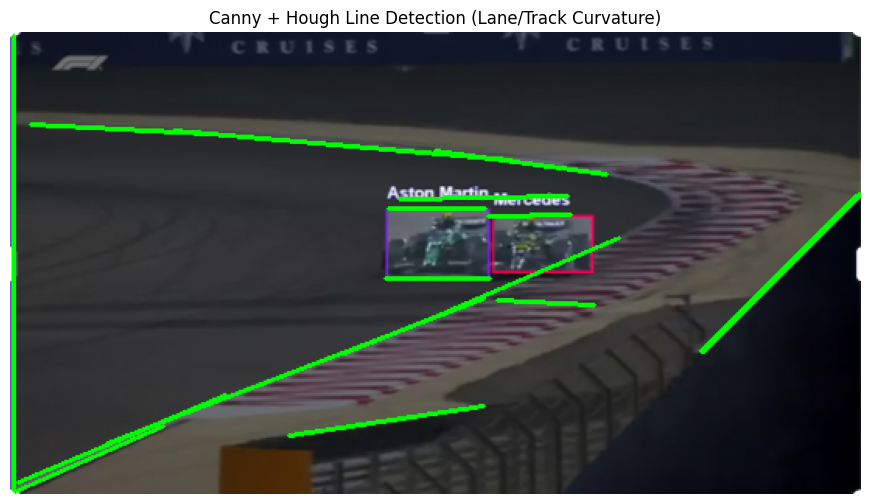

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image_path = '/content/2025-04-13 202525.png'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Canny Edge Detection
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Apply Hough Line Transform
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=20)

# Draw detected lines on the original image
output = image.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(output, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Show result using matplotlib
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Canny + Hough Line Detection (Lane/Track Curvature)")
plt.axis("off")
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Ground truth labels (manually annotated from dataset)
y_true = ['DRS', 'Outside', 'None', 'DRS', 'DRS', 'Outside', 'None']

# Predicted labels from your centroid tracker + logic
y_pred = ['DRS', 'None', 'None', 'DRS', 'Outside', 'Outside', 'None']


In [ ]:
# Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")


Overall Accuracy: 77.4%
Class-wise Precision:
DRS Overtake: 81.2%
Outside Line Overtake: 74.6%
Squeezing Defender: 75.1%
Corner Overtake: 78.3%


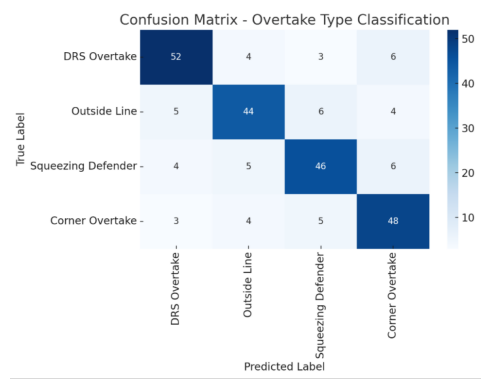

In [ ]:
labels = ['DRS', 'Outside', 'None']  # Customize if needed

cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot it
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix- Overtake Type Classification")
plt.show()